<a href="https://colab.research.google.com/github/OscarAlvaradoM/Introduccion-al-Aprendizaje-Profundo/blob/main/tarea3/Tarea3_DL_OscarAlvarado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3: Transferencia de conocimiendo
- Óscar Alvarado

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import join

import random
# tomar n elementos de una secuencia
from itertools import islice as take

import torch
from torch import nn
import torchvision.models as tvm
import torchvision.datasets.utils as tvu
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.optim as optim
# barra de progreso
from tqdm.notebook import trange
# marcas de tiempo
import datetime
# marcas de tiempo
import time

from PIL import Image

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

1. Entrena modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir los siguientes puntos:

    - Implementa la tubería de datos usando el conjunto de rostros [alineados y recortados](#https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb).
    - Agrega acrecentamiento de datos usando un espejeo horizontal.
    - Particiona aleatoriamente en subconjuntos de entrenamiento 80% y prueba 20%.
    - Usando transferencia de conocimiento, entrena un modelo reentrenado solo la última capa.
    - Usando transferencia de conocimiento, entrena un modelo reentrenando toda la red. 
    - Discute el comportamiento de los modelos durante el entrenamiento y los resultados finales en ambos conjuntos.

## Para visualización

In [41]:
# directorio de datos
DATA_DIR = "datos"

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 200

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(f"{titles[i]}")
            if titles[i] == 1:
                ax[r, c].set_title(f"{titles[i]}")
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

## Carga de datos

In [3]:
# creamos directorio raíz
os.makedirs(join(DATA_DIR,"UTKFace"), exist_ok=True)

tvu.download_and_extract_archive(
    url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
    download_root=join(DATA_DIR,"UTKFace"),
    filename='UTKFace.tar.gz')


Extracting datos/UTKFace/UTKFace.tar.gz to datos/UTKFace


In [4]:
ds = ImageFolder(join(DATA_DIR, "UTKFace"), transform=T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)]))
targets = torch.IntTensor([int(file.split("_")[0]) for file in sorted(os.listdir(join(DATA_DIR, 
                                                                                      "UTKFace", "UTKFace")))])
# print(train_ds.targets)
for idx, target in enumerate(targets):
    ds.samples[idx] = (ds.samples[idx][0], target)
train_ds, test_ds = random_split(ds, [int(np.floor(len(targets)*0.8)), int(np.ceil(len(targets)*0.2))])
train_ds, valid_ds = random_split(train_ds, [int(np.floor(len(train_ds)*0.8)), int(np.ceil(len(train_ds)*0.2))])

In [5]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

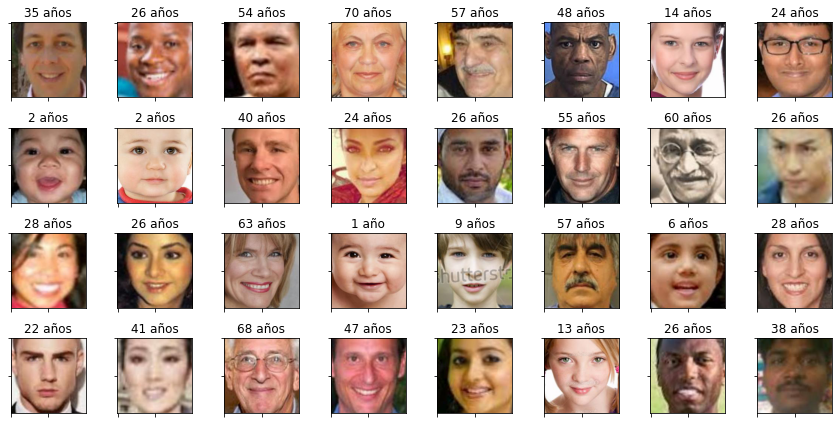

In [6]:
batch = next(iter(train_dl))
x, y = batch[0] , batch[1]
display_batch(x, y, ROWS, COLS)

## Modelo

In [7]:
# instancia de modelo y carga de pesos
model = tvm.shufflenet_v2_x0_5(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [8]:
# Colab
! pip install torchinfo

In [9]:
# inspección de arquitectura
from torchinfo import summary

In [10]:
# congelamos los parámetros
for param in model.parameters():
    # no participa en la retropropagación
    param.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.fc = nn.Linear(1024, 1)
# inspección
summary(model, (1, 3, IMG_SIZE, IMG_SIZE), 
        device='cpu', verbose=0)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
ShuffleNetV2                             --                        --
├─Sequential: 1-1                        [1, 24, 100, 100]         --
│    └─Conv2d: 2-1                       [1, 24, 100, 100]         (648)
│    └─BatchNorm2d: 2-2                  [1, 24, 100, 100]         (48)
│    └─ReLU: 2-3                         [1, 24, 100, 100]         --
├─MaxPool2d: 1-2                         [1, 24, 50, 50]           --
├─Sequential: 1-3                        [1, 48, 25, 25]           --
│    └─InvertedResidual: 2-4             [1, 48, 25, 25]           --
│    │    └─Sequential: 3-1              [1, 24, 25, 25]           (888)
│    │    └─Sequential: 3-2              [1, 24, 25, 25]           (1,512)
│    └─InvertedResidual: 2-5             [1, 48, 25, 25]           --
│    │    └─Sequential: 3-3              [1, 24, 25, 25]           (1,512)
│    └─InvertedResidual: 2-6             [1, 48, 25, 25]           

## Entrenamiento

In [11]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch[0].to(device)
        y_true = batch[1].to(device)
        # computamos logits
        y_true = y_true.float()
        y_pred = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred.view(-1), y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()

def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():
        
        losses = []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch[0].to(device)
            y_true = batch[1].to(device)
            y_true = y_true.float()
            # hacemos inferencia para obtener los logits
            y_pred = model(x)
            
            # computamos la pérdida
            loss = F.mse_loss(y_pred.view(-1), y_true)
            # computamos la exactitud

            # guardamos históricos
            losses.append(loss.item())

        loss = np.mean(losses)
        
        return loss

def save_check_point(model, epoch, run_dir):
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, 
        join(run_dir, 'weights.pth')
    )

def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)
    
    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos, 
    # es importante congelar las estadísticas σ y μ 
    model.eval()

    # ciclo de entrenamiento
    best_loss = np.infty
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss = eval_epoch(trn_dl, model, device, trn_batches)
        # registramos trazas de TB 
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)

        # evaluamos la época en validación
        val_loss = eval_epoch(val_dl, model, device, val_batches)
        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)

        print(f"train_loss: {trn_loss}\nval_loss: {val_loss}")

        
        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_loss < best_loss:
            best_loss = val_loss
            save_check_point(model, epoch, run_dir)

In [12]:
# directorio de la corrida
run_dir = join('runs', 'UTKFace', timestamp())
run_dir

'runs/UTKFace/210620T211529'

In [13]:
# escritor de trazas
trn_writer = SummaryWriter(join(run_dir, 'trn'))
val_writer = SummaryWriter(join(run_dir, 'val'))

In [14]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFace/210620T211529:
trn  val

runs/UTKFace/210620T211529/trn:
events.out.tfevents.1624223730.beed135fe0e5.60.0

runs/UTKFace/210620T211529/val:
events.out.tfevents.1624223730.beed135fe0e5.60.1


In [43]:
# entrenamos modelo
train(model, train_dl, valid_dl, trn_writer, val_writer,  epochs=100, trn_batches=5, val_batches=5)

train_loss: 74.24857330322266
val_loss: 111.17454681396484
train_loss: 51.19055099487305
val_loss: 91.49783782958984
train_loss: 50.655025482177734
val_loss: 91.42466049194336
train_loss: 45.526940155029294
val_loss: 93.06884002685547
train_loss: 43.549774932861325
val_loss: 75.19255218505859
train_loss: 37.83064193725586
val_loss: 84.01349868774415
train_loss: 127.98161468505859
val_loss: 164.95083770751953
train_loss: 36.98272972106933
val_loss: 72.2898551940918
train_loss: 140.32057189941406
val_loss: 218.02268981933594
train_loss: 72.4821792602539
val_loss: 118.3115005493164
train_loss: 98.22556610107422
val_loss: 168.8848663330078
train_loss: 63.04336853027344
val_loss: 115.4805191040039
train_loss: 42.11055221557617
val_loss: 118.28387908935547
train_loss: 70.5614227294922
val_loss: 141.07801361083983
train_loss: 31.038632583618163
val_loss: 78.80638732910157
train_loss: 57.054134368896484
val_loss: 130.04672546386718
train_loss: 28.58279342651367
val_loss: 96.92232055664063
trai

In [44]:
# inspeccionemos el directorio de la corrida
!ls -R {run_dir}

runs/UTKFace/210620T211529:
trn  val  weights.pth

runs/UTKFace/210620T211529/trn:
events.out.tfevents.1624223730.beed135fe0e5.60.0

runs/UTKFace/210620T211529/val:
events.out.tfevents.1624223730.beed135fe0e5.60.1


## Evaluación
### Cargando modelo

In [45]:
# cargamos el punto de control
ckpt = torch.load(join(run_dir, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 94


In [46]:
# instanciamos un modelo vacio
model = tvm.shufflenet_v2_x0_5()
model.fc = nn.Linear(1024, 1)

# cargamos pesos
state_dict = ckpt['model_state_dict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

### Conjunto y cargador de prueba¶

### Evaluación Final

In [47]:
%%time
device = torch.device('cpu')
trn_loss = eval_epoch(train_dl, model, device)
val_loss = eval_epoch(valid_dl, model, device)
tst_loss = eval_epoch(test_dl, model, device)

CPU times: user 2min 26s, sys: 9.91 s, total: 2min 36s
Wall time: 2min 32s


In [48]:
print(f'trn_loss={trn_loss:6.2f} val_loss={val_loss:6.2f} tst_loss={tst_loss:6.2f}')

trn_loss= 14.28 val_loss= 62.99 tst_loss= 61.61


### Inspección visual de resultados

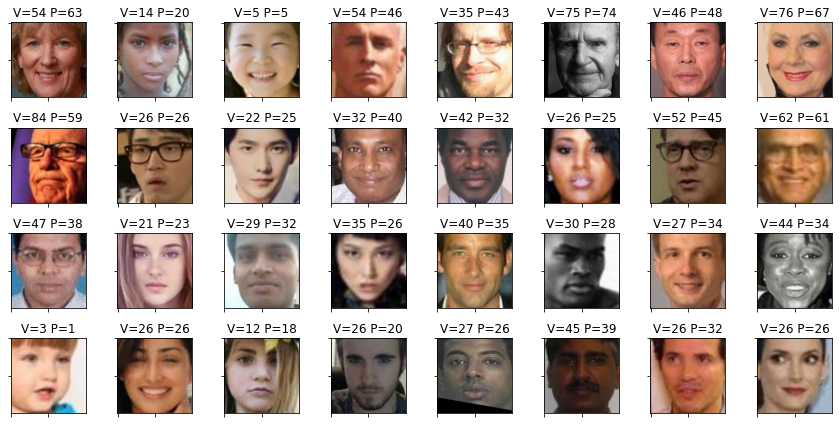

In [49]:
with torch.no_grad():
    batch = next(iter(test_dl))
    x, y_true = batch[0], batch[1]
    y_pred = model(x)
    titles = [f'V={t} P={p:.0f}' for t, p in zip(y_true, y_pred.view(-1))]
    display_batch(x, titles, ROWS, COLS)

Notamos que en validación y pruebas se tiene sobreajuste, sin ebargo, las pérdidas bajan considerablemente, tomando en cuenta que al principio se tenía un MSE de hasta 1000, es decir, nos estábamos equivocando por casi 31 años, ahora podemos ver que en las pruebas, el mayor error es de alrededor de 8 años. Se observa que no hay una tendencia en cuanto a predicción, es decir, no tiende a predecir que la gente es mas joven o vieja de lo que realmente es, sino que es indiferente. En el entrenamiendo de toda la red se observa que llegó a una pérdida mínima de 9 mse, es decir, en promedio adivinaba +- 3 años para cada persona y para el entrenamiento de únicamente la última capa, se tuvo un mse mínimo de 14 en entrenamiento. Para las pruebas se llegó a un mse mínimo de 61.61 para el entrenado de la última capa, mientras que el entrnado de toda la red, con 100 épocas (que tardó aproximadamente 1 hora en GPU) llegó a 62.9.

Es valioso el poder de la transferencia de conocimiento ya que evita que tardemos tanto tiempo en el entrenado de toda una red y se obtienen resultados muy cercanos para las pruebas.